In [8]:
# === Importações gerais ===
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from itertools import product
import time
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed

In [9]:
# === 1. Carregar o dataset ===
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
vinhos = pd.read_csv(url, sep=';')

# Separar variáveis independentes e dependente
X = vinhos.drop(columns=["quality"])
y = vinhos["quality"]

# Padronizar (essencial para redes neurais e regressões)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Configurar validação cruzada (10 folds)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)


=== Resultados Médios da Validação Cruzada (10-Fold) ===
              Modelo  R² Médio  MAE Médio  RMSE Médio
4      Random Forest    0.5051     0.4035      0.5649
5  Gradient Boosting    0.4175     0.4742      0.6130
1              Ridge    0.3447     0.5054      0.6509
0   Regressão Linear    0.3446     0.5054      0.6509
2              Lasso    0.3446     0.5056      0.6509
3  Rede Neural (MLP)    0.2721     0.5000      0.6838


/tmp/ipython-input-585937001.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Modelo", y="R² Médio", data=df_resultados, palette="viridis")


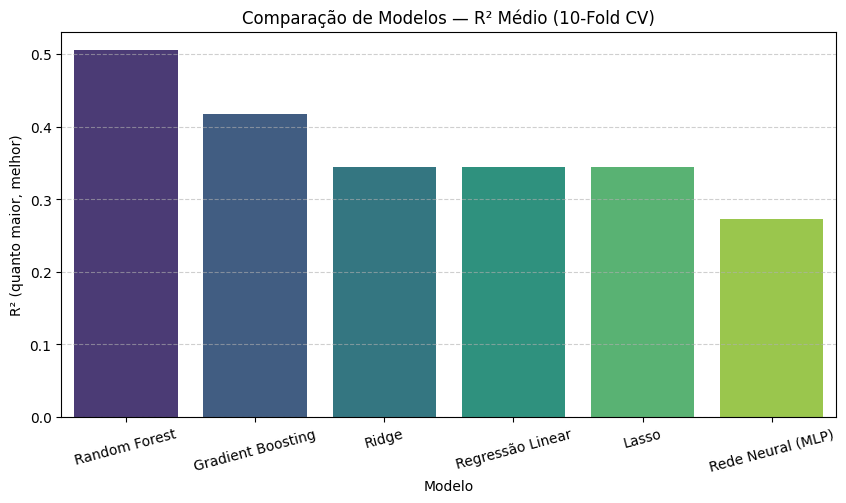

In [3]:
# === 2. Definição dos modelos ===
modelos = {
    "Regressão Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001),
    "Rede Neural (MLP)": MLPRegressor(hidden_layer_sizes=(100, 50),
                                      activation='relu',
                                      solver='adam',
                                      max_iter=1000,
                                      random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.05,
                                                   max_depth=3, random_state=42)
}

# === Funções auxiliares ===
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Avaliar modelos via validação cruzada
resultados = []

for nome, modelo in modelos.items():
    r2 = cross_val_score(modelo, X_scaled, y, cv=kfold, scoring='r2')
    mae = -cross_val_score(modelo, X_scaled, y, cv=kfold, scoring='neg_mean_absolute_error')
    rmse_vals = np.sqrt(-cross_val_score(modelo, X_scaled, y, cv=kfold, scoring='neg_mean_squared_error'))

    resultados.append({
        "Modelo": nome,
        "R² Médio": np.mean(r2),
        "MAE Médio": np.mean(mae),
        "RMSE Médio": np.mean(rmse_vals)
    })

df_resultados = pd.DataFrame(resultados).sort_values("R² Médio", ascending=False)
print("\n=== Resultados Médios da Validação Cruzada (10-Fold) ===")
print(df_resultados.round(4))

# === Visualização ===
plt.figure(figsize=(10,5))
sns.barplot(x="Modelo", y="R² Médio", data=df_resultados, palette="viridis")
plt.title("Comparação de Modelos — R² Médio (10-Fold CV)")
plt.ylabel("R² (quanto maior, melhor)")
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

In [4]:
# === 3. Hiperparâmetros reduzidos e otimizados ===
camadas = [1, 25, 125]
neuronios = [10, 50, 100]
ativacoes = ['relu', 'tanh']  # leaky_relu removida
early_stopping_opts = [True, False]
iteracoes = [1000, 2000]

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [5]:
# === 4. Funções auxiliares ===
def criar_arquitetura(n_camadas, n_neuronios):
    """Cria a tupla de camadas oculta."""
    return tuple([n_neuronios for _ in range(n_camadas)])

def treinar_e_avaliar(config):
    """Treina e avalia uma configuração da rede neural."""
    n_camadas, n_neuronios, ativacao, early, iters = config
    modelo = MLPRegressor(
        hidden_layer_sizes=criar_arquitetura(n_camadas, n_neuronios),
        activation=ativacao,
        solver='adam',
        max_iter=iters,
        early_stopping=early,
        random_state=42
    )
    r2 = cross_val_score(modelo, X_scaled, y, cv=kfold, scoring='r2', n_jobs=-1).mean()
    return {
        "Camadas": n_camadas,
        "Neurônios": n_neuronios,
        "Ativação": ativacao,
        "EarlyStopping": early,
        "Iterações": iters,
        "R² Médio": r2
    }

In [6]:
# === 5. Rodar os testes em paralelo ===
inicio = time.time()

configuracoes = list(product(camadas, neuronios, ativacoes, early_stopping_opts, iteracoes))
print(f"Total de configurações: {len(configuracoes)}")

# Paralelizar a execução
resultados_nn = Parallel(n_jobs=-1, backend="loky")(
    delayed(treinar_e_avaliar)(cfg) for cfg in configuracoes
)

fim = time.time()
print(f"\nTempo total de busca: {(fim - inicio)/60:.2f} minutos")

Total de configurações: 72


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Tempo total de busca: 61.04 minutos


In [7]:
# === 6. Analisar resultados ===
df_nn = pd.DataFrame(resultados_nn).sort_values("R² Médio", ascending=False)
print("\n=== Top 10 Configurações de Rede Neural ===")
print(df_nn.head(10).round(4))

df_nn.to_csv("resultados_redes_neurais_otimizados.csv", index=False)


=== Top 10 Configurações de Rede Neural ===
    Camadas  Neurônios Ativação  EarlyStopping  Iterações  R² Médio
22        1        100     tanh          False       1000    0.3934
23        1        100     tanh          False       2000    0.3934
20        1        100     tanh           True       1000    0.3847
21        1        100     tanh           True       2000    0.3847
15        1         50     tanh          False       2000    0.3836
14        1         50     tanh          False       1000    0.3836
13        1         50     tanh           True       2000    0.3663
12        1         50     tanh           True       1000    0.3663
7         1         10     tanh          False       2000    0.3632
6         1         10     tanh          False       1000    0.3632


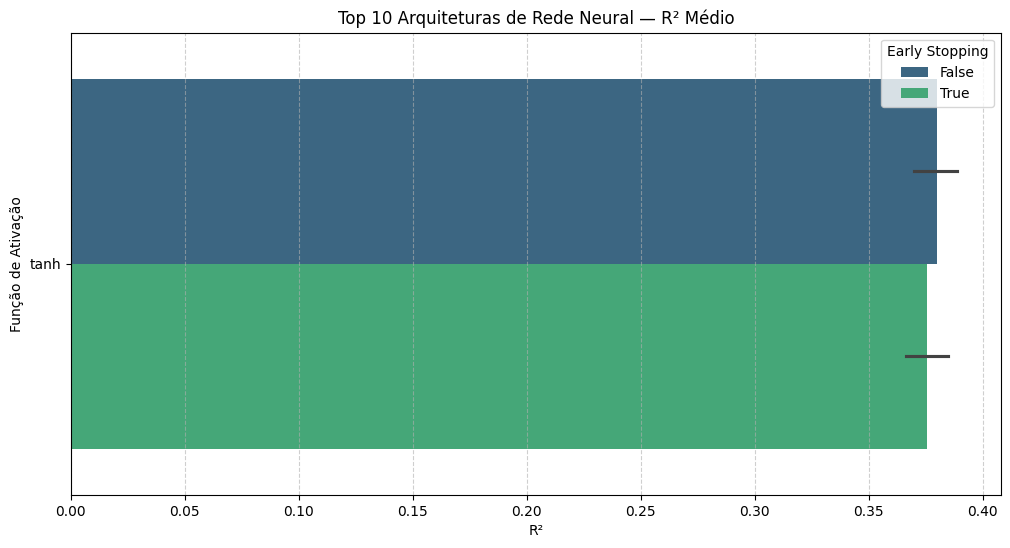

In [10]:
# === 7. Visualização ===
plt.figure(figsize=(12,6))
sns.barplot(x="R² Médio", y="Ativação", hue="EarlyStopping", data=df_nn.head(10), orient='h', palette="viridis")
plt.title("Top 10 Arquiteturas de Rede Neural — R² Médio")
plt.xlabel("R²")
plt.ylabel("Função de Ativação")
plt.legend(title="Early Stopping")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()